# divide observations into watermasses based on location

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import cmocean as cm
import gsw

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2, mode
from scipy.spatial.distance import mahalanobis

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('./filtered_obs.csv')

In [3]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so split into summer and winter datasets before we do this
# in the future i would like to split this data up based on the actual timing of upwelling and downwelling, but for now lets just do this simple separation 

wob = obs[(obs.month >=11) | (obs.month <=2)]
sob = obs[(obs.month >= 5) & (obs.month <=8)]

In [4]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

def TS(df,region,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df['salinity (g kg-1)'][df.region == region].reset_index(drop=True)
    temp = df['temperature (degC)'][df.region == region].reset_index(drop=True)

    bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
    data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    ax.scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)

    title = region + "\n n= " + str(len(salt))
    ax.set_title(title)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def TS_depth(df,region,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df['salinity (g kg-1)'][df.region == region].reset_index(drop=True)
    temp = df['temperature (degC)'][df.region == region].reset_index(drop=True)
    z = df['depth (m)'][df.region == region].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]
                    
    sc = ax.scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Depth [m]', labelpad=10, fontsize=14)
    
    ax.set_title(region)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def xy_depth(df,region,ax):

    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

    lon = df['longitude (degrees_east)'][(df.region == region)].reset_index(drop=True)
    lat = df['latitude (degrees_north)'][(df.region == region)].reset_index(drop=True)
    z = df['depth (m)'][(df.region == region)].reset_index(drop=True)
    idx = z.argsort()
    lon, lat, z = lon[idx], lat[idx], z[idx]

    ax.scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
    ax.set_title(region)

In [36]:
############
# ELLIPSES #
############

def confidence_ellipse(x, y, ax, n_std=1, **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x_valid, y_valid)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor='none', **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x_valid), np.mean(y_valid))

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

def percentile_ellipse(x, y, ax, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, mean, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, facecolor='none', **kwargs)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)
    return subset_mean[0], subset_mean[1], width, height, angle

def percentile_mode_ellipse(x, y, ax, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    this one is centered around the mode of the data instead of the mean
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    dmode = mode(data, axis=0)[0]
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, dmode, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, facecolor='none', **kwargs)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)
    

In [66]:
######################
# BOX PLOT FUNCTIONS #
######################

def box(df,regions,property,ax,**kwargs):
    tracer = [df[property][df.region==region] for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ticks = ["{}\n{}".format(regions[i],str(len(t_filter[i]))) for i in range(len(regions))]
    ax.set_xticklabels(ticks,rotation=30,ha='right')
    ax.set_ylabel(property)

    return bplot

In [6]:
# SUMMER DIVISIONS

# all water masses are important in the summer (according to Lagrangian analysis) which complicates separation a bit

# CUC = slope water south of 50.5 & salinity greater than or equal to 33.8 (need to do sensitivity analysis on this salinity choice)
# north shelf = shelf water north of 49, slope water north of 49 in the top 200 m 
# south shelf = shelf water south of 47.3, slope was south of 47.3 with salinity less than 33.8
# brackish = salinity less than or equal to 32
# offshore = offshore of 2000 m contour

sob['region'] = 'none'
sob.region[sob.location == 'offshore'] = 'offshore'
sob.region[(sob.location == 'shelf') & (sob['latitude (degrees_north)'] >= 49)] = 'north'
sob.region[(sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3)] = 'south'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] >= 49) & (sob['depth (m)'] <= 200)] = 'north'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] < 33.7)] = 'south'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 50.5) & (sob['salinity (g kg-1)'] >= 33.7)] = 'cuc'
sob.region[sob['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

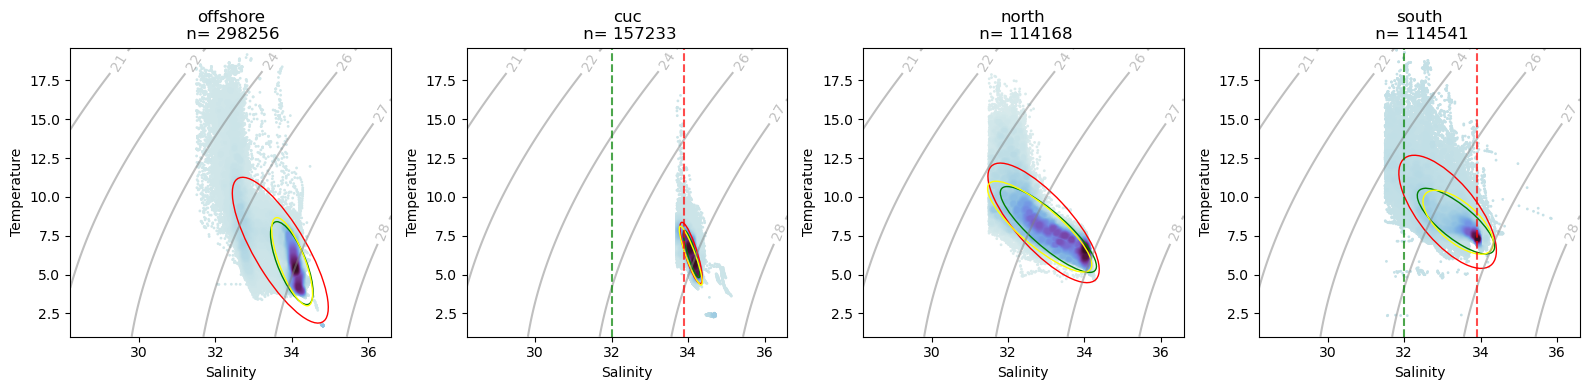

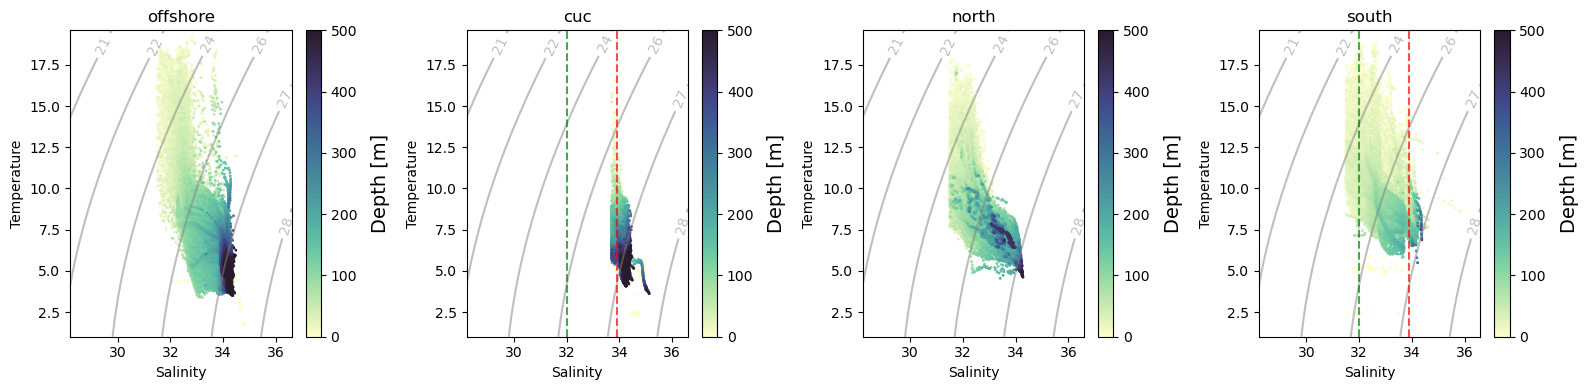

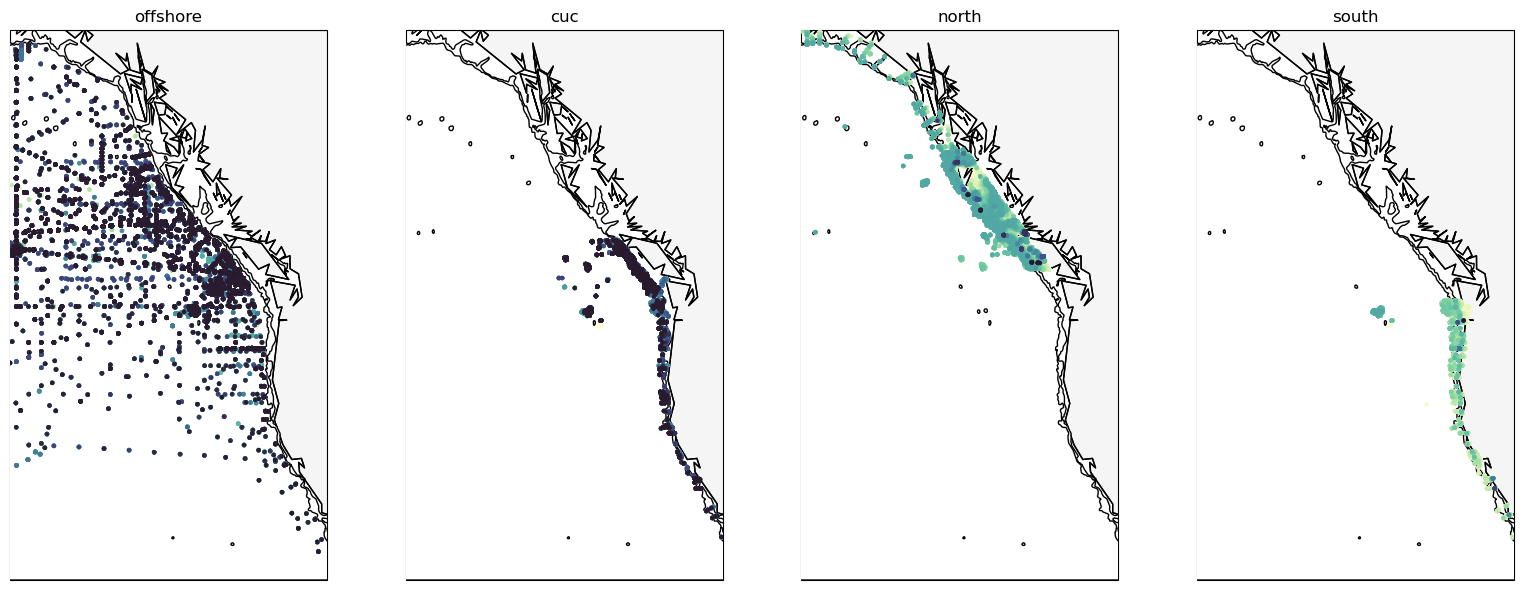

In [80]:
regions = ['offshore', 'cuc', 'north', 'south']

#elipse information
x_mean, y_mean, width, height, angle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*4,4])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i])
    confidence_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], n_std=2, edgecolor='red')
    x_mean[i], y_mean[i], width[i], height[i], angle[i] = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], percentile=75, edgecolor='green')
    percentile_mode_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], percentile=75, edgecolor='yellow')


# show boundaries from CIOPS analysis
ax[1].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[1].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[3].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[3].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*4,4])
for i in range(len(ax)):
    TS_depth(sob,regions[i],ax[i])
# show boundaries from CIOPS analysis
ax[1].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[1].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[3].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[3].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

xlim, ylim = [-145.5, -120.2], [30, 60]
fig, ax = plt.subplots(1,4, figsize=(len(regions)*4,6), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
for i in range(len(ax)):
    xy_depth(sob,regions[i],ax[i])
plt.tight_layout()

Text(0.5, 0, 'Salinity (g kg$^{-1}$)')

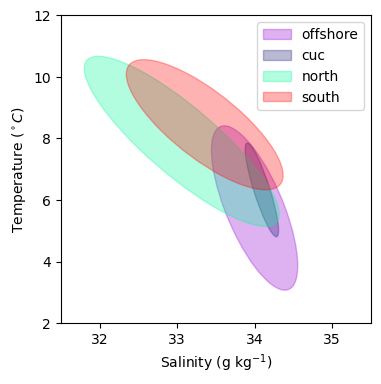

In [50]:
# lets plot all the ellipses together
colour = ['darkviolet','midnightblue','mediumspringgreen','red']

fig, ax = plt.subplots(1,1,figsize=[4,4])

for i in range(len(regions)):
    # Create the ellipse
    ellipse = Ellipse((x_mean[i], y_mean[i]),
                      width=width[i], height=height[i],
                      angle=angle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3,
                      label=regions[i])

    # Add the ellipse to the plot
    ax.add_patch(ellipse)

ax.set_ylim([2,13])
ax.set_xlim([31,35.5])
ax.legend()
ax.set_ylabel('Temperature ($^\circ C$)')
ax.set_xlabel('Salinity (g kg$^{-1}$)')

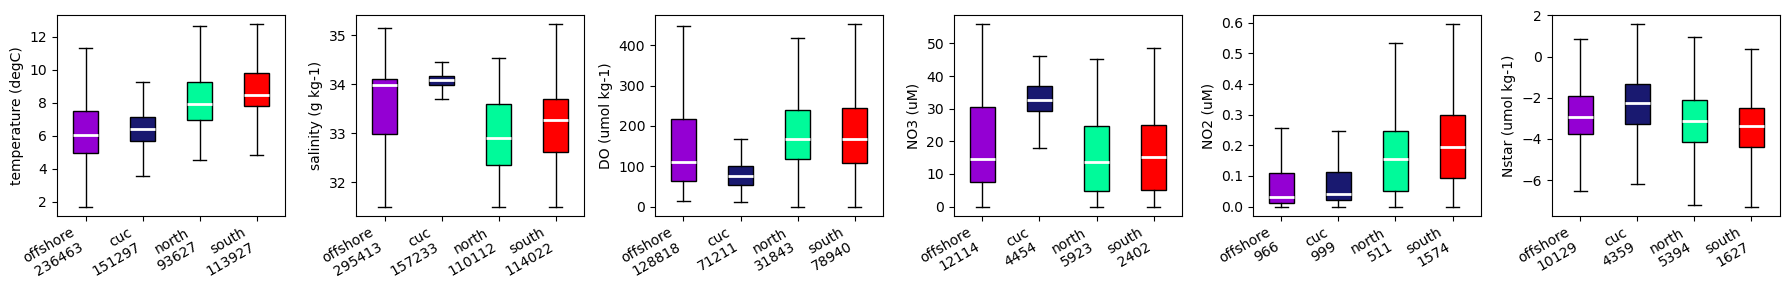

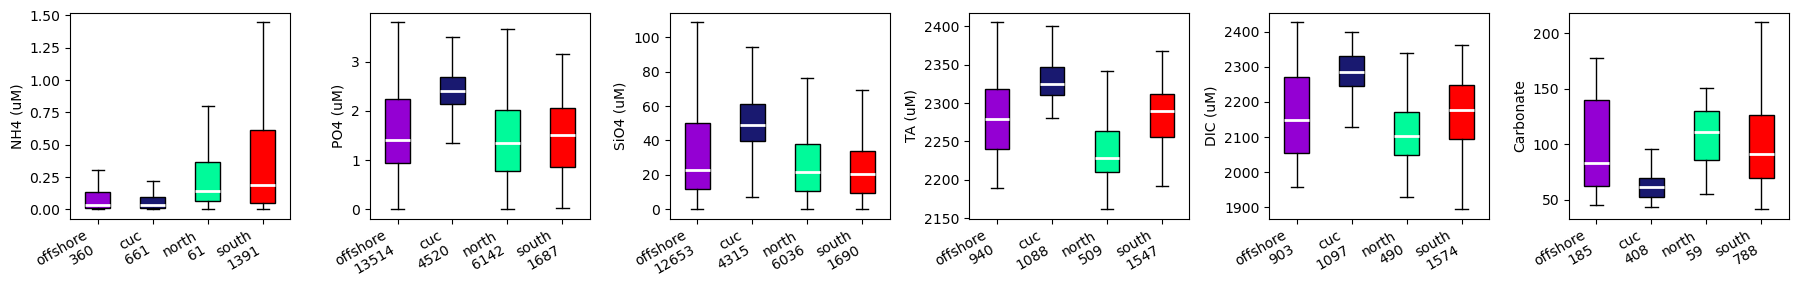

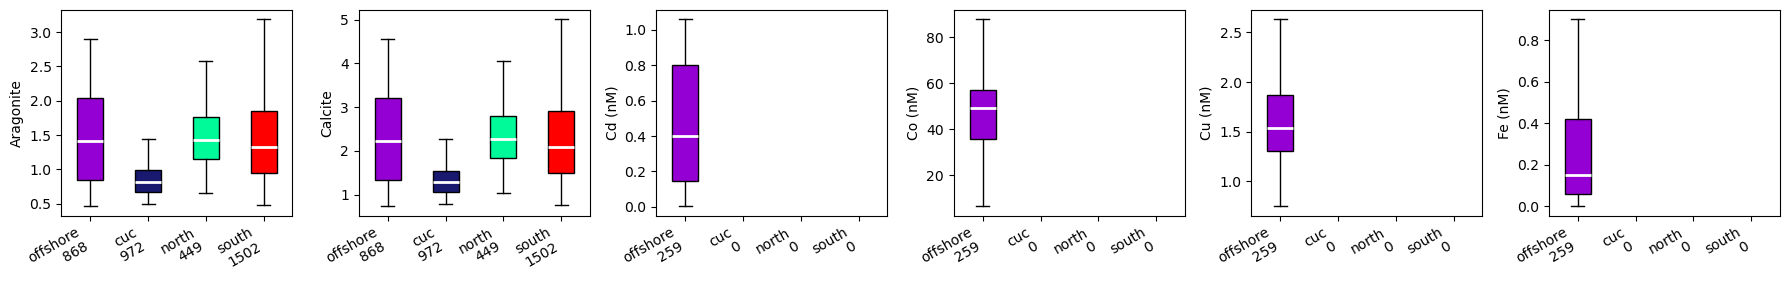

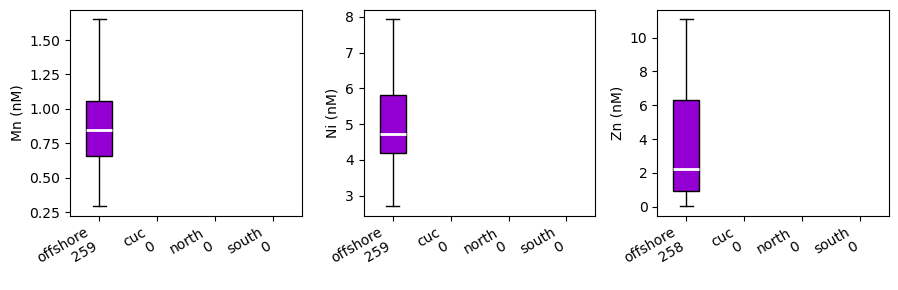

In [76]:
# box plots of different tracers
colour = ['darkviolet','midnightblue','mediumspringgreen','red']

properties = ['temperature (degC)','salinity (g kg-1)','DO (umol kg-1)','NO3 (uM)','NO2 (uM)', 'Nstar (umol kg-1)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)', 'Carbonate']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['Aragonite', 'Calcite','Cd (nM)', 'Co (nM)', 'Cu (nM)','Fe (nM)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['Mn (nM)','Ni (nM)', 'Zn (nM)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_linewidth(2)
plt.tight_layout()
    

In [9]:
# WINTER DIVISIONS

# really just south water important in the winter so i think the results will be less sensitive to N/S spatial divisions
# i'm also less worried about the JdF Eddy, so maybe its ok to take points near the entrance to the salish sea

# CUC = slope water south of 50.5 & salinity greater than or equal to 33.8 (need to do sensitivity analysis on this salinity choice)
# north shelf = shelf water north of 50.5, slope water north of 50.5 in the top 200 m
# south shelf = shelf water south of 50.5, slope water south of 50.5 with salinity less than 33.8
# brackish = salinity less than or equal to 32
# offshore = offshore of 2000 m contour

wob['region'] = 'none'
wob.region[wob.location == 'offshore'] = 'offshore'
wob.region[(wob.location == 'shelf') & (wob['latitude (degrees_north)'] >= 49)] = 'north'
wob.region[(wob.location == 'shelf') & (wob['latitude (degrees_north)'] <= 47.3)] = 'south'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] >= 49) & (wob['depth (m)'] <= 200)] = 'north'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] < 33.7)] = 'south'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 50.5) & (wob['salinity (g kg-1)'] >= 33.7)] = 'cuc'
wob.region[wob['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

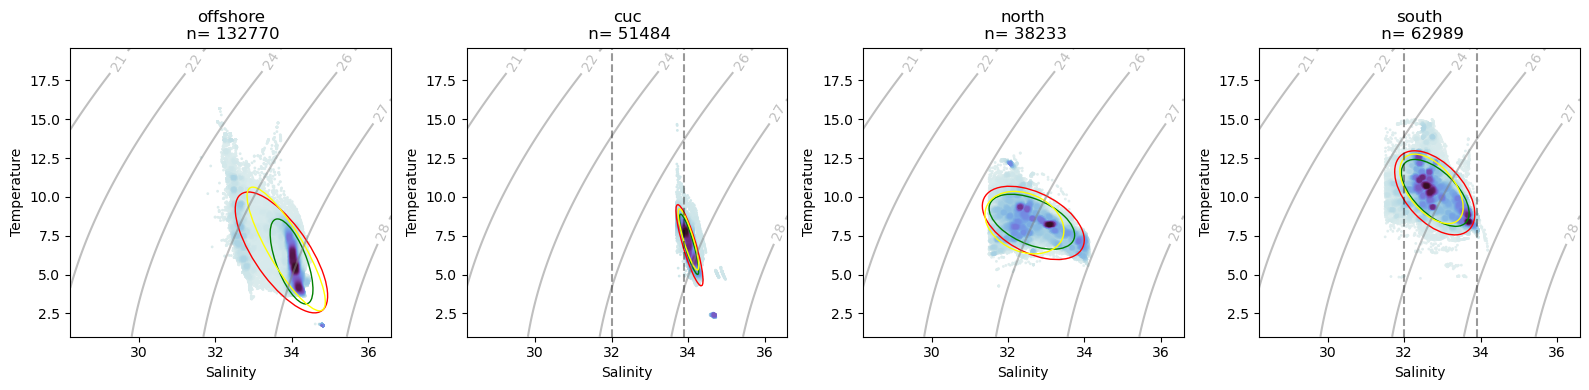

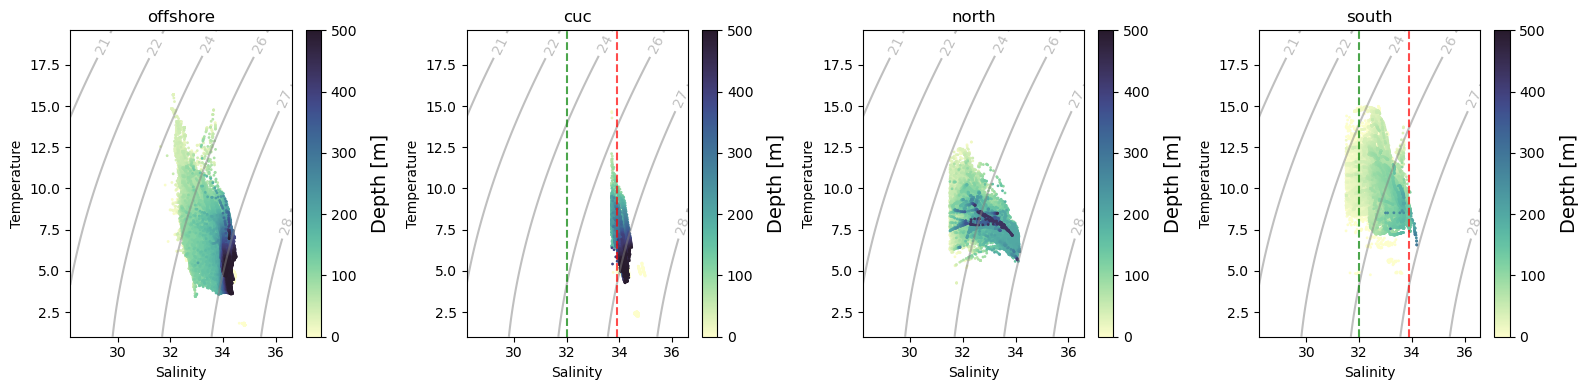

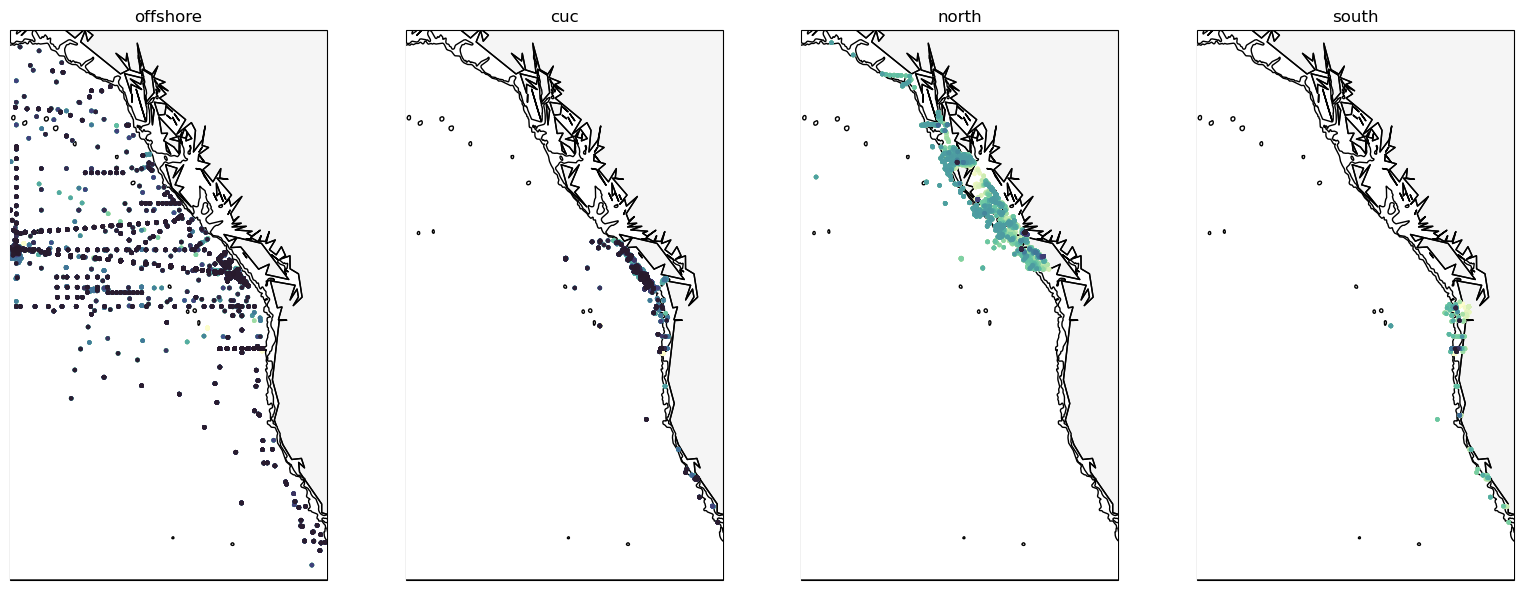

In [81]:
regions = ['offshore', 'cuc', 'north', 'south']

#elipse information
Wx_mean, Wy_mean, Wwidth, Wheight, Wangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*4,4])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i])
    confidence_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], n_std=2, edgecolor='red')
    Wx_mean[i], Wy_mean[i], Wwidth[i], Wheight[i], Wangle[i] = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], percentile=75, edgecolor='green')
    percentile_mode_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], percentile=75, edgecolor='yellow')


# show boundaries from CIOPS analysis
ax[1].plot([33.9,33.9],[tmin,tmax],'k--', alpha=0.4, label='Deep division')
ax[1].plot([32,32],[tmin,tmax],'k--',alpha=0.4,label='Columbia division')
ax[3].plot([33.9,33.9],[tmin,tmax],'k--', alpha=0.4, label='Deep division')
ax[3].plot([32,32],[tmin,tmax],'k--',alpha=0.4,label='Columbia division')

plt.tight_layout()

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*4,4])
for i in range(len(ax)):
    TS_depth(wob,regions[i],ax[i])
# show boundaries from CIOPS analysis
ax[1].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[1].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[3].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[3].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

xlim, ylim = [-145.5, -120.2], [30, 60]
fig, ax = plt.subplots(1,4, figsize=(len(regions)*4,6), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
for i in range(len(ax)):
    xy_depth(wob,regions[i],ax[i])
plt.tight_layout()

Text(0.5, 0, 'Salinity (g kg$^{-1}$)')

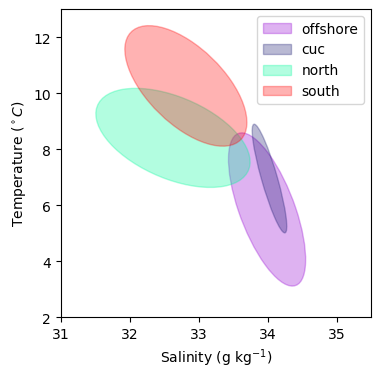

In [82]:
# lets plot all the ellipses together
colour = ['darkviolet','midnightblue','mediumspringgreen','red']

fig, ax = plt.subplots(1,1,figsize=[4,4])

for i in range(len(regions)):
    # Create the ellipse
    ellipse = Ellipse((Wx_mean[i], Wy_mean[i]),
                      width=Wwidth[i], height=Wheight[i],
                      angle=Wangle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3,
                      label=regions[i])

    # Add the ellipse to the plot
    ax.add_patch(ellipse)

ax.set_ylim([2,13])
ax.set_xlim([31,35.5])
ax.legend()
ax.set_ylabel('Temperature ($^\circ C$)')
ax.set_xlabel('Salinity (g kg$^{-1}$)')

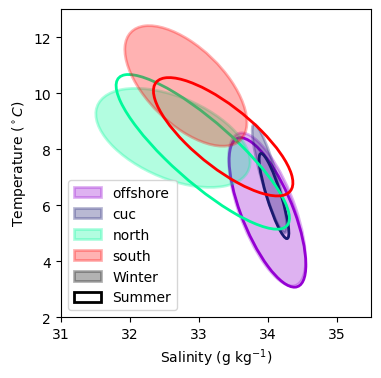

In [89]:
# compare summer and winter ellipses
# lets plot all the ellipses together
colour = ['darkviolet','midnightblue','mediumspringgreen','red']

fig, ax = plt.subplots(1,1,figsize=[4,4])

for i in range(len(regions)):
    # Create the ellipse
    ellipse = Ellipse((Wx_mean[i], Wy_mean[i]),
                      width=Wwidth[i], height=Wheight[i],
                      angle=Wangle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3, lw=2,
                      label=regions[i])

    # Add the ellipse to the plot
    ax.add_patch(ellipse)
    ellipse = Ellipse((x_mean[i], y_mean[i]),
                      width=width[i], height=height[i],
                      angle=angle[i], facecolor='none', 
                      edgecolor=colour[i],lw=2)
    # Add the ellipse to the plot
    ax.add_patch(ellipse)

ax.set_ylim([2,13])
ax.set_xlim([31,35.5])
ax.set_ylabel('Temperature ($^\circ C$)')
ax.set_xlabel('Salinity (g kg$^{-1}$)')


# these ellipses added outside of view for the sake of the legend
# Create the ellipse
ellipse = Ellipse((Wx_mean[i]+100, Wy_mean[i]+100),
                      width=Wwidth[i], height=Wheight[i],
                      angle=Wangle[i], facecolor='k', 
                      edgecolor='k',alpha=0.3,
                      lw=2,label='Winter')

    # Add the ellipse to the plot
ax.add_patch(ellipse)
ellipse = Ellipse((x_mean[i]+100, y_mean[i]+100),
                      width=width[i], height=height[i],
                      angle=angle[i], facecolor='none', 
                      edgecolor='k',lw=2,label='Summer')
# Add the ellipse to the plot
ax.add_patch(ellipse)

ax.legend()

#### NOTE: my summer and winter CUC definition overlaps well with ~40% PEW line (Newport - Vancouver Island Shelf) in figure 1 of Thomson and Krassovski (2010) for water between around 150-300 m deep

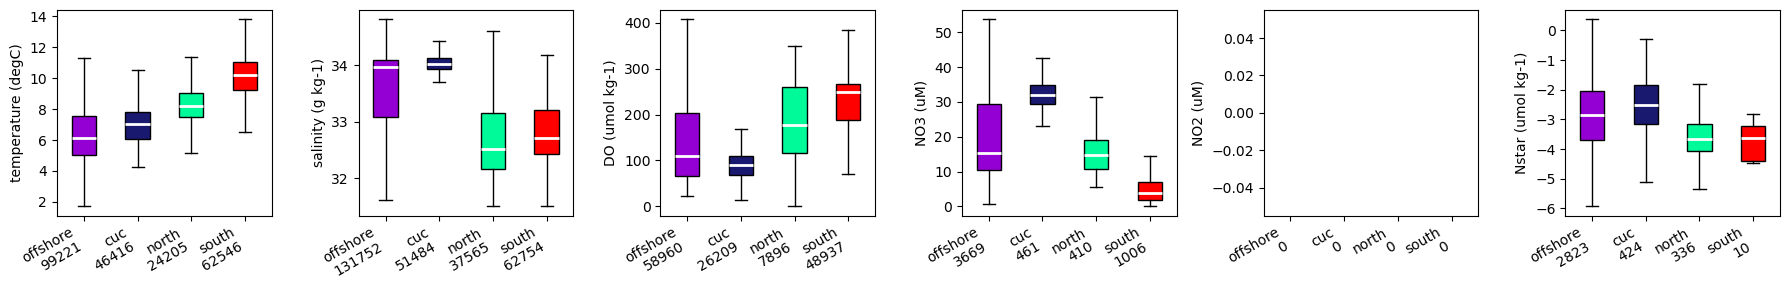

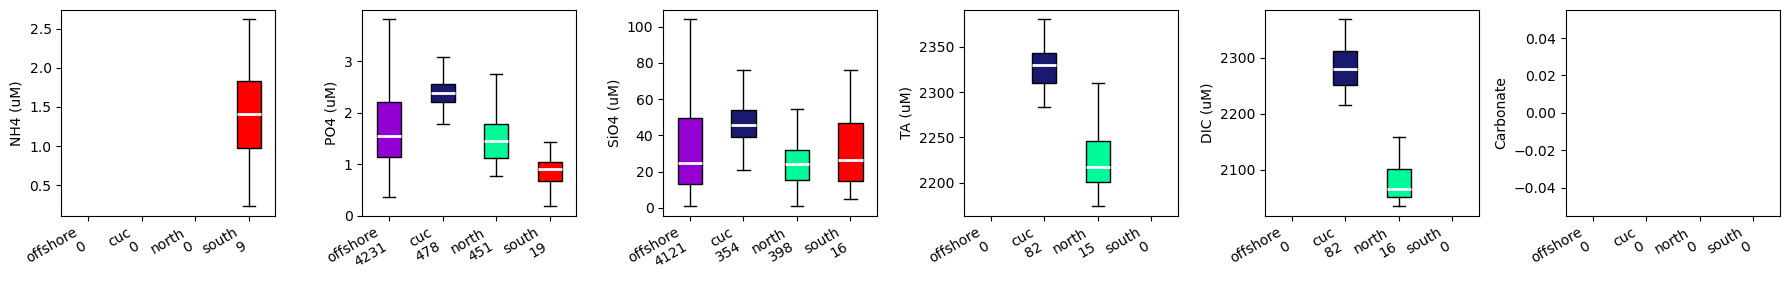

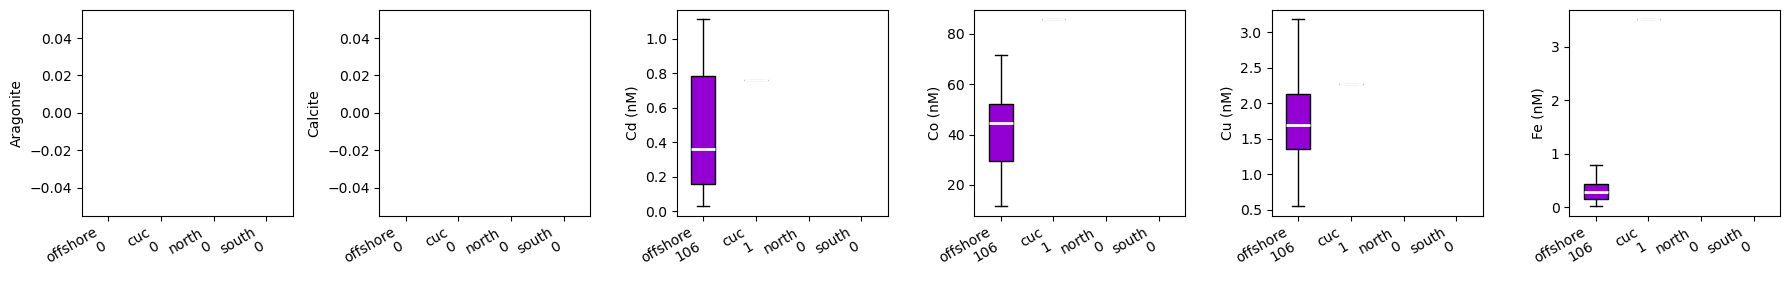

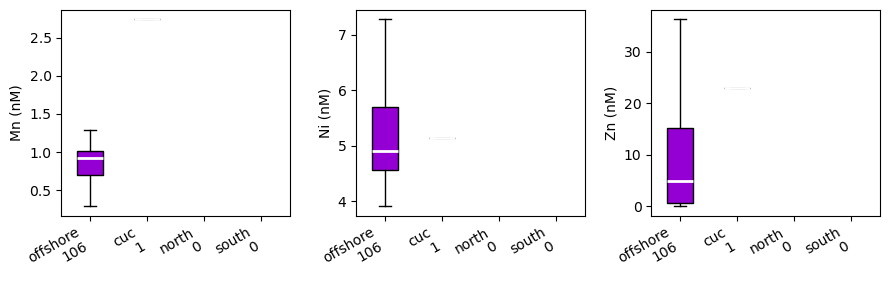

In [83]:
# box plots of different tracers
colour = ['darkviolet','midnightblue','mediumspringgreen','red']

properties = ['temperature (degC)','salinity (g kg-1)','DO (umol kg-1)','NO3 (uM)','NO2 (uM)', 'Nstar (umol kg-1)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)', 'Carbonate']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['Aragonite', 'Calcite','Cd (nM)', 'Co (nM)', 'Cu (nM)','Fe (nM)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['Mn (nM)','Ni (nM)', 'Zn (nM)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('white')
        median.set_linewidth(2)
plt.tight_layout()